In [138]:
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from shutil import copyfile


import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [142]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [143]:
train_generator = train_datagen.flow_from_directory('Train',
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

valid_generator = valid_datagen.flow_from_directory('Validation',
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

Found 3600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [144]:
def label_to_index(label):
    label = label.replace(' ', '')
    label = label.replace('[', '')
    label = label.replace(']', '')
    
    index = 0
    for i in label:
        if i == '0':
            index += 1
        if i == '1':
            break

    return index

In [145]:
def show_images(generator, nRows = 1, nCols = 2, WidthSpace = 0.02, HeightSpace = 0.15):
    """
    Plots random num_images images from generator

    Args:
        generator: a generator instance
        nRows: number of rows
        nCols: number of columns
        WidthSpace: width space
        HeightSpace: height space
    """
    global emotions
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace)
    
    images, labels = generator.next()
    labels = labels.astype('int32')
    num_images = nRows * nCols
    
    
    plt.figure(figsize=(20,10))
    
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(gs[i])
        plt.imshow(image)
        label = label_to_index(str(label))
        plt.title(emotions[label])
        if i == num_images - 1:
            break
    plt.show()
        

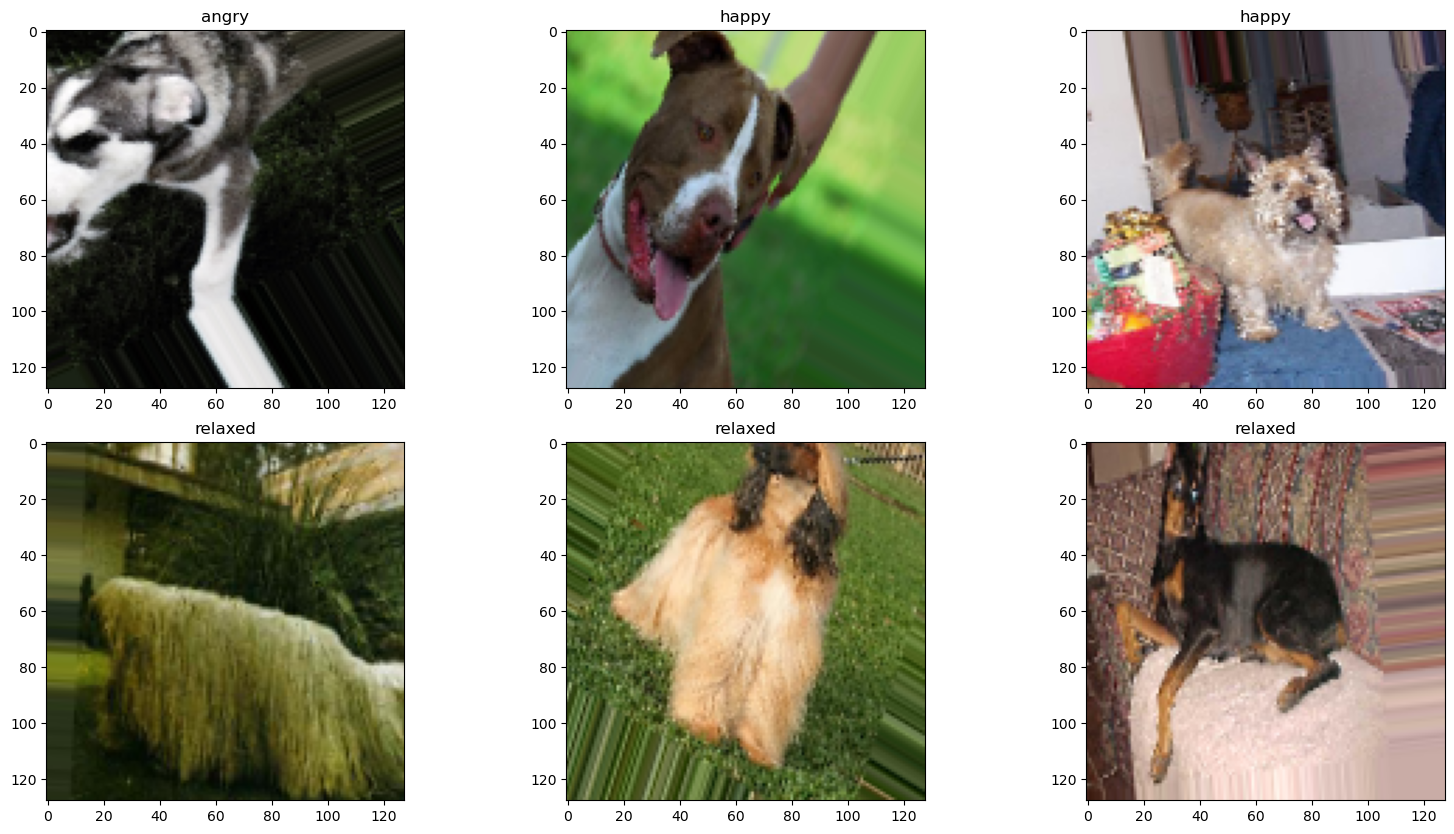

In [146]:
show_images(train_generator, 2, 3)

In [147]:
# Load model 
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in inception.layers[:-10]:
    layer.trainable = False
    
last_layer = inception.get_layer('mixed7')

print('Last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

Last layer output shape:  (None, 6, 6, 768)


In [148]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(4, activation='softmax')(x)
model = Model(inception.input, predictions)

In [149]:
def scheduler(epoch, learning_rate):
    if epoch < 20:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.2)

callback = LearningRateScheduler(scheduler)

In [150]:
# Set the training parameters
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [151]:
history = model.fit(train_generator,    
                    validation_data = valid_generator,
                    epochs=100, callbacks=[callback], verbose=1
                    steps_per_epoch=10)

Epoch 1/25
36/36 [==============================] - 53s 1s/step - loss: 1.8533 - accuracy: 0.4792 - val_loss: 1.3312 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 2/25
36/36 [==============================] - 44s 1s/step - loss: 1.4346 - accuracy: 0.5672 - val_loss: 1.2385 - val_accuracy: 0.5675 - lr: 1.0000e-04
Epoch 3/25
36/36 [==============================] - 44s 1s/step - loss: 1.3757 - accuracy: 0.5844 - val_loss: 1.1299 - val_accuracy: 0.5850 - lr: 1.0000e-04
Epoch 4/25
36/36 [==============================] - 42s 1s/step - loss: 1.2942 - accuracy: 0.6086 - val_loss: 1.0261 - val_accuracy: 0.6575 - lr: 1.0000e-04
Epoch 5/25
36/36 [==============================] - 44s 1s/step - loss: 1.1852 - accuracy: 0.6339 - val_loss: 1.2034 - val_accuracy: 0.5875 - lr: 1.0000e-04
Epoch 6/25
36/36 [==============================] - 44s 1s/step - loss: 1.1928 - accuracy: 0.6361 - val_loss: 1.1695 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 7/25
36/36 [==============================] - 43s 1s

KeyboardInterrupt: 